### Final Model

In [319]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [320]:
df = pd.read_csv("train_combined.csv")

In [321]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,CALC,MTRANS,WeightCategory,BMI,HeightWeightRatio,BMIxGender,BMI_FAF,BMI_sq,Weight_sq,Obesity_Type_III_Profile
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2,3,Sometimes,...,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,0.020815,28.259565,0.000000,798.603001,6669.980733,0
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2,3,Frequently,...,no,Automobile,Normal_Weight,23.422091,0.027368,0.000000,23.422091,548.594334,3249.000000,0
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,2,1,Sometimes,...,no,Public_Transportation,Insufficient_Weight,17.126706,0.034116,0.000000,14.832498,293.324052,2516.602874,0
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3,3,Sometimes,...,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,0.013032,0.000000,65.842167,2012.042650,17233.086505,1
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,3,2,Sometimes,...,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,0.020408,25.599151,50.378438,655.316531,8798.075122,0


In [322]:
test_df = pd.read_csv('test_final.csv')
test_ids = test_df['id']

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17644 entries, 0 to 17643
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  float64
 1   Gender                          17644 non-null  object 
 2   Age                             17644 non-null  float64
 3   Height                          17644 non-null  float64
 4   Weight                          17644 non-null  float64
 5   family_history_with_overweight  17644 non-null  object 
 6   FAVC                            17644 non-null  object 
 7   FCVC                            17644 non-null  int64  
 8   NCP                             17644 non-null  int64  
 9   CAEC                            17644 non-null  object 
 10  SMOKE                           17644 non-null  object 
 11  CH2O                            17644 non-null  float64
 12  SCC                             

In [324]:
numeric_features = [
    'Age', 'Height', 'Weight', 'BMI','BMIxGender' 
    , 'CH2O', 'FAF', 'TUE'
]

categorical_features = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'FCVC', 'NCP',
      'CALC', 'MTRANS', 'SCC','SMOKE'
    	
]

In [325]:
le = LabelEncoder()
y = le.fit_transform(df['WeightCategory'])

In [326]:
X = df[numeric_features + categorical_features]
X_test_submission = test_df[numeric_features + categorical_features]
X.shape

(17644, 18)

In [327]:
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_features),
                                               ('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

In [328]:
preprocessor.fit(X)

X_train_processed_array = preprocessor.transform(X)
X_test_processed_array = preprocessor.transform(X_test_submission)

feature_names = preprocessor.get_feature_names_out()

X_train_processed = pd.DataFrame(X_train_processed_array, columns=feature_names, index=X.index)
X_test_processed = pd.DataFrame(X_test_processed_array, columns=feature_names, index=X_test_submission.index)

In [329]:
# Set up 5-Fold Cross-Validation
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [330]:
# XGBoost model
model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),  
    random_state=42,
    
    n_jobs=-1,
    device='cuda',        
    tree_method='hist'    
)

In [331]:
param_grid_6 = {
    'n_estimators': [950],
    'learning_rate': [0.043],
    'max_depth': [4],
    'min_child_weight': [2],
    'subsample': [0.7],         
    'colsample_bytree': [ 0.78],  
    'gamma': [0.1],
    'reg_alpha': [0.1],
    'reg_lambda': [4]
    }

In [332]:
# GridSearchCV
grid_search_xgb6 = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_6,
    cv=k_folds,
    scoring='accuracy',
    n_jobs=1,  
    verbose=2
)

In [333]:
grid_search_xgb6.fit(X_train_processed, y)

results_df5 = pd.DataFrame(grid_search_xgb6.cv_results_)

print(f"Best XGBoost CV Accuracy: {grid_search_xgb6.best_score_ * 100:.3f}%")
print(f"Best XGBoost Parameters: {grid_search_xgb6.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.78, gamma=0.1, learning_rate=0.043, max_depth=4, min_child_weight=2, n_estimators=950, reg_alpha=0.1, reg_lambda=4, subsample=0.7; total time= 1.9min
[CV] END colsample_bytree=0.78, gamma=0.1, learning_rate=0.043, max_depth=4, min_child_weight=2, n_estimators=950, reg_alpha=0.1, reg_lambda=4, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.78, gamma=0.1, learning_rate=0.043, max_depth=4, min_child_weight=2, n_estimators=950, reg_alpha=0.1, reg_lambda=4, subsample=0.7; total time=   9.8s
[CV] END colsample_bytree=0.78, gamma=0.1, learning_rate=0.043, max_depth=4, min_child_weight=2, n_estimators=950, reg_alpha=0.1, reg_lambda=4, subsample=0.7; total time=   9.9s
[CV] END colsample_bytree=0.78, gamma=0.1, learning_rate=0.043, max_depth=4, min_child_weight=2, n_estimators=950, reg_alpha=0.1, reg_lambda=4, subsample=0.7; total time=   9.9s
Best XGBoost CV Accuracy: 91.345%
Best XGBoost Para

In [334]:
best_model2 = grid_search_xgb6.best_estimator_
predictions_numeric2 = best_model2.predict(X_test_processed)
predictions_labels2 = le.inverse_transform(predictions_numeric2)

**Feature importance**

In [335]:
feature_names = preprocessor.get_feature_names_out()


importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model2.feature_importances_ 
    }).sort_values(by='Importance', ascending=False)    
   

In [316]:
importance_df.head(10)

,Feature,Importance
29,cat__Obesity_Type_III_Profile_0,0.176656
7,num__BMI_sq,0.146599
3,num__BMI,0.115912
30,cat__Obesity_Type_III_Profile_1,0.108891
12,cat__Gender_Female,0.097450
4,num__BMIxGender,0.058851
13,cat__Gender_Male,0.047638
2,num__Weight,0.022918
8,num__Weight_sq,0.020511
16,cat__FAVC_no,0.013289


In [296]:
#top 20
top_n = 20
importance_df_top = importance_df.head(top_n) 

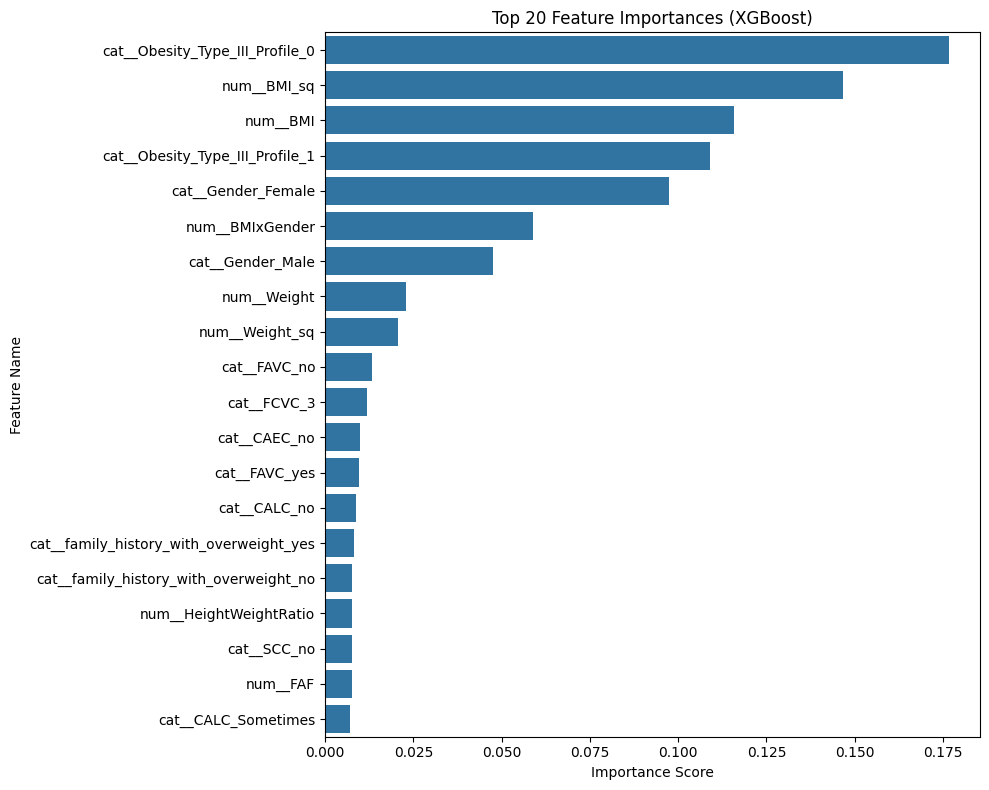

In [297]:
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.barplot(x='Importance', y='Feature', data=importance_df_top)
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()

**generate submission file**

In [337]:
# Submission file XGB with regularization best model
submission_df2 = pd.DataFrame({
    'id': test_ids,
    'NObeyesdad': predictions_labels2})

In [338]:
submission_df2.to_csv('submission_XGB_regul_final.csv', index=False)